# Australian Open Predicition

## Data Loading

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Suppress warngings from chunks
from warnings import simplefilter
simplefilter('ignore')

In [2]:
# Get current working directory
src =  os.getcwd()
# Load data for male players
maleDF = pd.read_csv(src+'\\data\\ATP_matches.csv')
# Load data for female players
femaleDF = pd.read_csv(src+'\\data\\WTA_matches.csv')
# Load Data for Testing
maleFullDF = pd.read_csv(src+'\\testing\\ATP_matches_final.csv')
femaleFullDF = pd.read_csv(src+'\\testing\\WTA_matches_final.csv')

# Display tensor sizes
print("==== TRAINING ====")
print("Male data: \n" + str(maleDF.shape[0]) + " Observations of " + str(maleDF.shape[1]) + " Variables\n")
print("Female Data: \n" + str(femaleDF.shape[0]) + " Observations of " + str(femaleDF.shape[1]) + " Variables")
print("\n==== FULL SET ====")
print("Male data: \n" + str(maleFullDF.shape[0]) + " Observations of " + str(maleFullDF.shape[1]) + " Variables\n")
print("Female Data: \n" + str(femaleFullDF.shape[0]) + " Observations of " + str(femaleFullDF.shape[1]) + " Variables")

==== TRAINING ====
Male data: 
20807 Observations of 35 Variables

Female Data: 
13906 Observations of 35 Variables

==== FULL SET ====
Male data: 
20967 Observations of 35 Variables

Female Data: 
14041 Observations of 35 Variables


In [3]:
# Create testing set from Final and Training
newDates = maleFullDF['Tournament_Date'].unique()[-3:]
maleTestDF = maleFullDF[maleFullDF['Tournament_Date'].isin(newDates)]
femaleTestDF = femaleFullDF[femaleFullDF['Tournament_Date'].isin(newDates)]

## Data Cleaning

In [4]:
from scripts.DataCleaning import \
replaceMissingWithNaN, replaceMissingWithZero, \
changeDataTypes

In [5]:
# Convert missing entries to Nan
replaceMissingWithNaN(maleDF)
replaceMissingWithNaN(maleTestDF)
replaceMissingWithNaN(femaleDF)
replaceMissingWithNaN(femaleTestDF)

In [6]:
# Check the datatypes of variables loaded
# List of Catagorical data
catagories = {'Winner', 'Loser', 'Tournament', 'Tournament_Date',
              'Court_Surface', 'Round_Description'}
# Boolean
boolean = {'Retirement_Ind'}

# Numeric that should keep missing values
numeric = {'Winner_Rank', 'Loser_Rank'}

changeDataTypes(maleDF, catagories, boolean, numeric)
changeDataTypes(maleTestDF, catagories, boolean, numeric)
changeDataTypes(femaleDF, catagories, boolean, numeric)
changeDataTypes(femaleTestDF, catagories, boolean, numeric)

# Summary Statistics

In [7]:
# Grab Summary Statistic scripts
from scripts.SummaryStatistics import \
summariseLifetimePlayerStats, summarisePlayerTournStats, \
summarisePlayerSurfaceStats, addServeStatistics

In [8]:
# Names of total summary columns
statCols = ['Total_Sets_Won', 'Total_Games_Won', 'Total_Aces', 'Total_DoubleFaults', \
            'Total_FirstServes_Won', 'Total_FirstServes_In', 'Total_SecondServes_Won', \
            'Total_SecondServes_In', 'Total_BreakPoints_Won','Total_BreakPoints', \
            'Total_ReturnPoints_Won', 'Total_ReturnPoints_Faced', 'Total_Points_Won']

In [9]:
# Calculate lifetime summary statistics and Tournament Summaries for Male Players
maleTournSummaryDF = summarisePlayerTournStats(maleDF, statCols)
maleLifeSummaryDF = summariseLifetimePlayerStats(maleDF, statCols)
maleSurfaceSummaryDF = summarisePlayerSurfaceStats(maleDF, statCols)
maleServeSummaryDF = addServeStatistics(maleLifeSummaryDF)
maleTournServeDF = addServeStatistics(maleTournSummaryDF)
maleSurfaceServeDF = addServeStatistics(maleSurfaceSummaryDF)

In [10]:
# Calculate lifetime summary statistics and Tournament Summaries for Male Players
femaleLifeSummaryDF = summariseLifetimePlayerStats(femaleDF, statCols)
femaleServeSummaryDF = addServeStatistics(femaleLifeSummaryDF)

## Univariate Visualisation

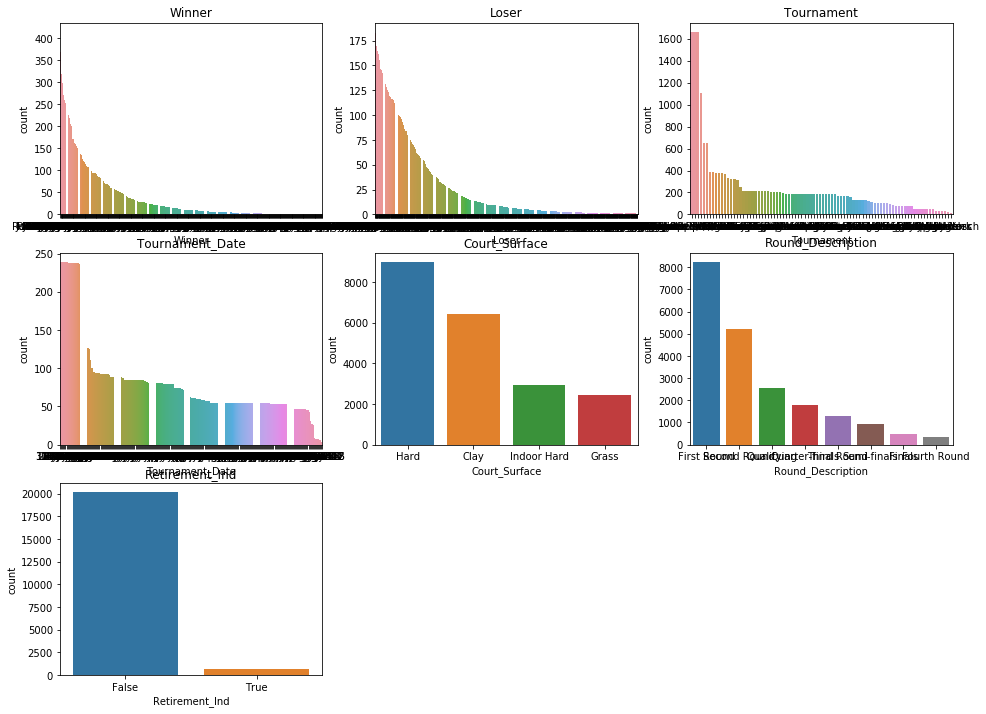

In [11]:
# Frequency of observations for different catagorical variables
# Long run time!
f = plt.figure(figsize=(16, 12))
counter = 1

for variable in list(maleDF.columns.values):
    if maleDF[variable].dtype.name == 'category' or maleDF[variable].dtype.name == 'bool':
        f.add_subplot(3, 3, counter)
        plt.title(variable)
        sns.countplot(x = variable, 
                      data = maleDF,
                      order = maleDF[variable].value_counts().index)
        counter +=1
        
# Save the plot
plt.savefig(src+'\\img\\AllCatagoricalBarCharts')  

These barcharts show the sample representation proportions of different categoires that split the data. Of particular interest is the a player that wins more often is likely to play more game overall than players how lose creating a sampling skew towards winners. Explicitly observed in the first two charts showing the highest sampled winner has over 400 matches recorded and the highest sampled loser is sampled slightly over 175 times. Tournament and Date are sampled in similar ways, starting with a large number of intial samples into a uniform mid-season and an undersampled final tournament. This is reflected in the structure of the overall season of the sport as players are intialy knocked out rapidly, play off and qualify for the final event. This is also seen in the sampling of rounds in each tournament with a large number of first round matches exponentially decaying towards the finals. Matches are most likely to be played on Hard or Clay surfaces that are outdoors, Grass being the least represented surface. The final chart shows that it is rare for a player to retire from a match.

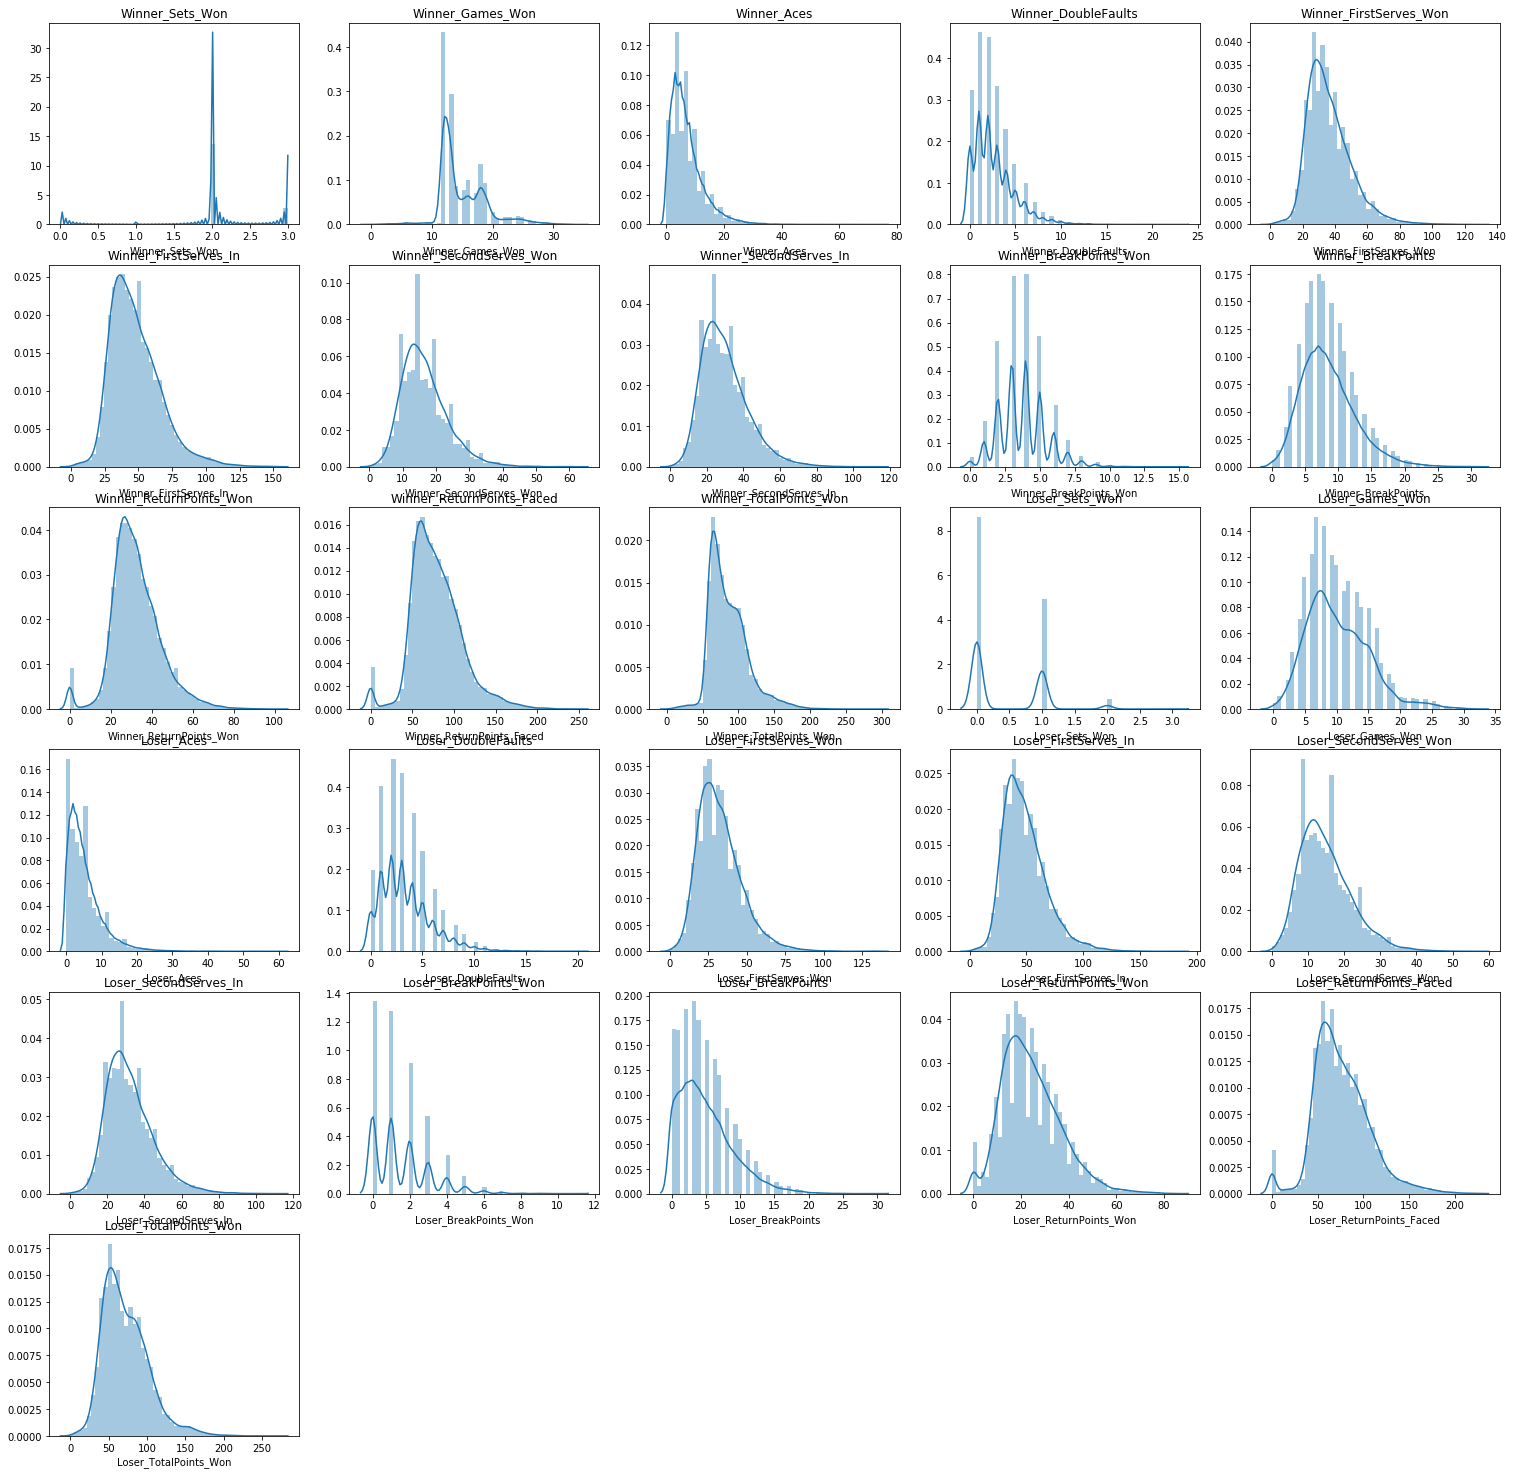

In [12]:
# Histograms for numeric data
f = plt.figure(figsize=(26, 26))
counter =1

for variable in list(maleDF.columns.values):
    if maleDF[variable].dtype.name == 'int64':
        f.add_subplot(6, 5, counter)
        plt.title(variable)
        sns.distplot(maleDF[variable])
        counter +=1
        
# Save the plot
plt.savefig(src+'\\img\\AllDiscreteHistograms')  

The above histograms relating to total points show that although a player is a loser/winner the ditribution of how many points they win overall approximates a normal distribution. In each distributions winners are have a higher observed mean than losers.  but the overall kurtosis and variance appear to be shared.

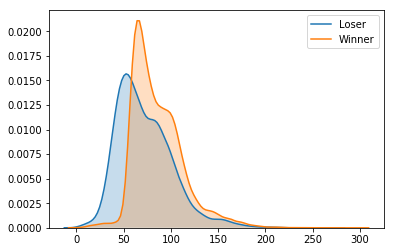

In [13]:
# An example of how the distribution of total points follows the a trend under some mean shift
snsPlot = sns.kdeplot(maleDF['Loser_TotalPoints_Won'], label = 'Loser', shade = True)
snsPlot = sns.kdeplot(maleDF['Winner_TotalPoints_Won'], label = 'Winner', shade = True)
snsPlot.figure.savefig(src+"\\img\\TotalPointsWon.png")

# Bivariate Analysis

In [14]:
# Ungroup dataframe for analysis
maleTournServeDF = maleTournServeDF.reset_index()

## Court Surface

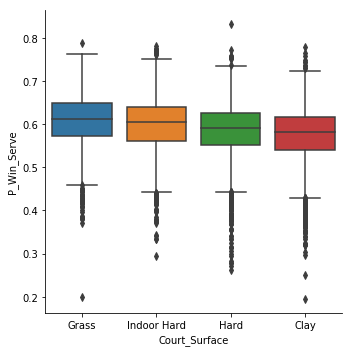

In [15]:
# Boxplot to compare court surfaces
snsPlot = sns.catplot(x='Court_Surface', y='P_Win_Serve',
            kind = "box", order = ['Grass', 'Indoor Hard', \
                                  'Hard', 'Clay'],
            data = maleTournServeDF)

snsPlot.savefig(src+"\\img\\CourtSurface-Box.png")

In [16]:
# Fit a linear relationship
lm = ols('P_Win_Serve ~ Court_Surface', 
         data = maleTournServeDF).fit()
# One-way anova
aov_table = sm.stats.anova_lm(lm, typ = 2)
display(aov_table)

,sum_sq,df,F,PR(>F)
Court_Surface,1.152319,3.0,91.172294,3.443537e-58
Residual,41.253431,9792.0,NaN,NaN


From the above one-way ANOVA table a significant difference in the mean probability of winning a serve exists for different court surfaces.  

In [17]:
# Between group comparisons
mc = MultiComparison(maleTournServeDF['P_Win_Serve'], 
                     maleTournServeDF['Court_Surface'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1    group2   meandiff  lower   upper  reject
--------------------------------------------------
 Clay     Grass     0.0318   0.0261  0.0376  True 
 Clay      Hard     0.0111   0.0071  0.0152  True 
 Clay  Indoor Hard  0.0242   0.0192  0.0293  True 
Grass      Hard    -0.0207  -0.0263 -0.0151  True 
Grass  Indoor Hard -0.0076   -0.014 -0.0012  True 
 Hard  Indoor Hard  0.0131   0.0082  0.018   True 
--------------------------------------------------


The result of the post-hoc between group Tukey test shows their is significant evidence to support differences in the mean probability of winning a serve on each court surface 

## Tournament

In [18]:
# Fit a linear relationship
lm = ols('P_Win_Serve ~ Tournament', 
         data = maleTournServeDF).fit()
# One-way anova
aov_table = sm.stats.anova_lm(lm, typ = 2)

# Fit a linear relationship
lm = ols('P_Win_Serve ~ Court_Surface + Tournament', 
         data = maleTournServeDF).fit()
# One-way anova
aov_table = sm.stats.anova_lm(lm, typ = 2)

# Fit a linear relationship
lm = ols('P_Win_Serve ~ Tournament*Court_Surface', 
         data = maleTournServeDF).fit()
# One-way anova
aov_table = sm.stats.anova_lm(lm, typ = 2)

Although there is evidence to suggest a significant differnece between group means the the residual when comparing the model to court surface alone explains a very small aditional amount. This slight increase comes at the expense of including a variable that may need up to 86 independent terms without including interactions. Additonaly as a predictor it is not generalisable to new tournaments.

The last ANOVA table shows that a model including the Tournament variable does not gain any significant amount of information from also including court surface. This is likely a result of tournaments being played on a uniform surface throughout, making tournament inclusive of any differences observed in court surface alone. Additonal information that the tournament beings to the model could be generalised by feature engineering. This might be achieved by using the date and location of the tournament to create variables relating to climate and weather that may be implicity contained within each existing catagory.

## Player

In [19]:
# Fit a linear relationship
lm = ols('P_Win_Serve ~ Player', 
         data = maleTournServeDF).fit()
# One-way anova
aov_table = sm.stats.anova_lm(lm, typ = 2)

Not surprisingly when splitting the matches into groups assigned to unique players a linear model with the lowest residual and most significant difference is found. However this presents a chicken and egg senario where a player requires their own data before a prediction can be made using their model. This is a strong indicator that players may need a seperate probability distribution to draw from, making use of Baysian priors for unknown players. 

## Continuous Predictors

## Individual Matches

In [20]:
# Calulate the correlation matrix
corr = abs(maleTournServeDF.corr())

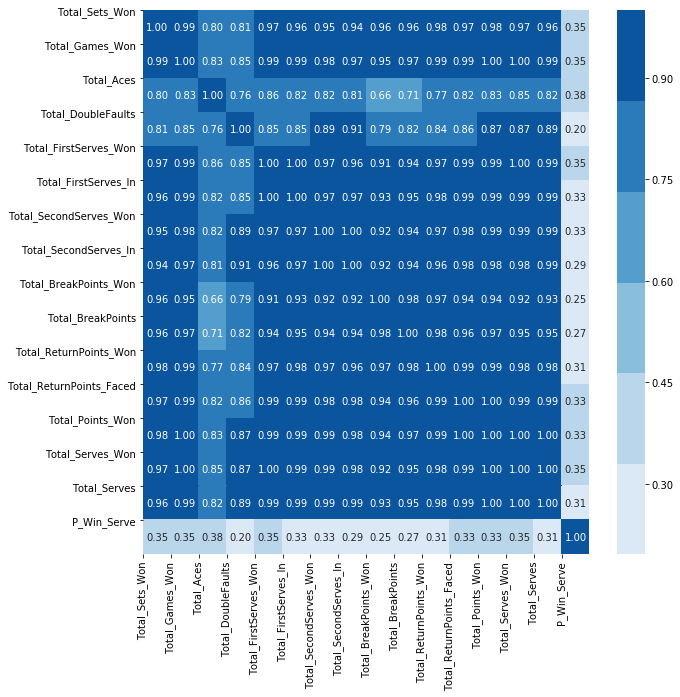

In [21]:
# Create a large plot
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a heatmap
colourmap = sns.color_palette("Blues")
snsPlot = sns.heatmap(corr, annot = True,
                     fmt='.2f', cmap = colourmap)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
# Save the plot
plt.savefig(src+"\\img\\CorelationMatrix-matches.png")

Most of the lifetime summary statistics show a slight linear corelation with a players average probability of winning a serve. Several of more highely corelated variables are directly related to serves. 

In [22]:
# Drop variable directly used in the calulation of P_W_serve
corr = corr.drop(corr.filter(regex='Serves'), axis = 1)
corr = corr.transpose()
corr = corr.drop(corr.filter(regex='Serves'), axis = 1)
# Drop itself
corr = pd.DataFrame(corr['P_Win_Serve'])
corr = corr[:-1]

In [23]:
# Make the largest model from all corelated continuous variable
# Including two-way interaction terms
model = 'P_Win_Serve ~ ('
for variable in list(corr.transpose().columns): 
    model += variable + ' + '
# Add court surface
model += 'Court_Surface)**2'

largestLM = ols(model, data = maleTournServeDF).fit()

In [24]:
aov_table = sm.stats.anova_lm(largestLM, typ = 2)
sigAOVTable = aov_table[aov_table['PR(>F)']  <= 0.05].sort_values(['PR(>F)'])

It can be seen that the most significant predictors for the probability of winning a serve have direct links to player competency, with main effects from Games Won, Break Points Won and Double Faults ranking highly.

In [25]:
# Fit a regularised model from the significant terms idenified above
model = 'P_Win_Serve ~ '
for variable in list(sigAOVTable.transpose().columns): 
    model += variable + ' + '
model = model[:-3]

# LASSO
lassoLM = ols(model, data = maleTournServeDF).fit_regularized(method = 'elastic_net', L1_wt = 1)

In [26]:
lassoDF = pd.DataFrame(lassoLM.params)
lassoDF.columns = ['Coefficent']
# Filter coeficients less than 0.05%
lassoDF = lassoDF[(lassoDF['Coefficent'] >= 0.0005) | (lassoDF['Coefficent'] <= -0.0005)]

Most of the significant terms in remaining contain some posterior information about the match relating to the total number of times something occured. As the current dataframes are only considering matches and not lifetime player summaries these are not very useful in making predictions on unseen matches. However the intercept of 0.551 and coefficents relating to court surface can be used to inform a prior for a players probability to win a serve.

P_Win_Serve = 0.550825 + 0.023224 Grass + 0.008945 Hard + 0.022339 IndoorHard

## Lifetime Statistics

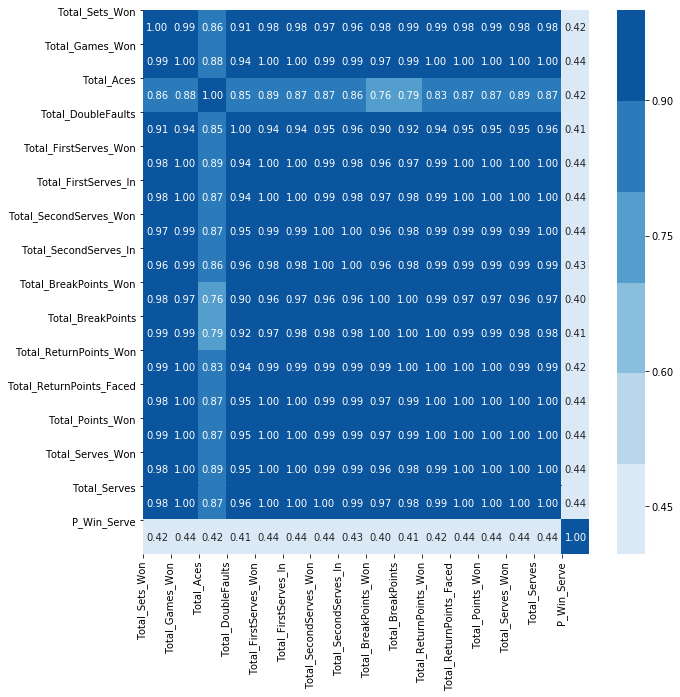

In [27]:
corr = abs(maleServeSummaryDF.corr())

# Create a large plot
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a heatmap
colourmap = sns.color_palette("Blues")
snsPlot = sns.heatmap(corr, annot = True,
                     fmt='.2f', cmap = colourmap)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
# Save the plot
plt.savefig(src+"\\img\\CorelationMatrix-lifetime.png")
plt.show()

In [28]:
# Drop variable directly used in the calulation of P_W_serve
corr = corr.drop(corr.filter(regex='Serves'), axis = 1)
corr = corr.transpose()
corr = corr.drop(corr.filter(regex='Serves'), axis = 1)
# Drop itself
corr = pd.DataFrame(corr['P_Win_Serve'])
corr = corr[:-1]

In [29]:
# Make the largest model from all corelated continuous variable
# Including two-way interaction terms
model = 'P_Win_Serve ~ ('
for variable in list(corr.transpose().columns): 
    model += variable + ' + '

model = model[:-3] +')**2'
largestLM = ols(model, data = maleServeSummaryDF).fit()

In [30]:
aov_table = sm.stats.anova_lm(largestLM, typ = 2)
sigAOVTable = aov_table[aov_table['PR(>F)']  <= 0.05].sort_values(['PR(>F)'])

Lifetime stats are seen to have less significance than game statistics, but they are available before a match in order to inform the prior probability. As seen before the variables seen as significant in the ANOVA analysis primarily relate to player ability.

In [31]:
# Fit a regularised model from the significant terms idenified above
model = 'P_Win_Serve ~ '
for variable in list(sigAOVTable.transpose().columns): 
    model += variable + ' + '
model = model[:-3]

# LASSO
lassoLM = ols(model, data = maleServeSummaryDF).fit_regularized(method = 'elastic_net', L1_wt = 1)

In [32]:
lassoDF = pd.DataFrame(lassoLM.params)
lassoDF.columns = ['Coefficent']
# Filter coeficients less than 0.00001%
lassoDF = lassoDF[(lassoDF['Coefficent'] >= 0.000001) | (lassoDF['Coefficent'] <= -0.000001)]

Inherantly this model preforms the regularisation of the totals which skews player who are sampled more often.

# Probability functions

In [33]:
from scripts import MatchWinProbCalc as MWPC

In [34]:
X = np.linspace(0,1, num = 1000)
Y = np.arange(0.1,1,0.1)

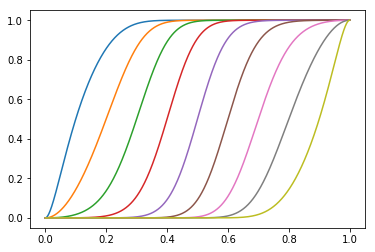

In [35]:
for y in Y:
    plt.plot( X, MWPC.match_win_2_of_3(X, y))

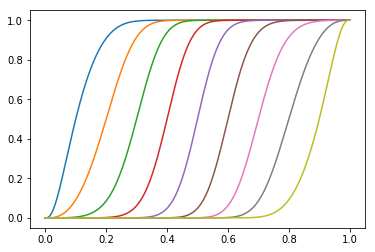

In [36]:
for y in Y:
    plt.plot( X, MWPC.match_win_3_of_5(X, y))

In [37]:
MWPC.match_win_3_of_5(0.8,0.6)

0.9980939157449831

In [38]:
MWPC.match_win_2_of_3(0.668309, 0.696297)

0.36944123128243067

In [39]:
MWPC.match_win_2_of_3(0.5, 0.5)

0.5

# Model Output

In [40]:
from scripts.OutputGeneration import generateOutputDF

If there is not data for a player, return default_prob as the probability they win a rally on their serve
    Note that the below function takes a summary_dataframe with an index of player names and a column title P_Win_Serve.
    Thus to change the probabilities being run through the model, we need only create a new dataframe of rally probabilities 
    indexed by player. These probabilities could be empirical lifetime averages, averages over the last tournament, averages over
    the court type to be used in the upcoming tournament, the result of bayesian inference etc.

In [41]:
# Load provided sample submissions
femaleSampleSubmission = pd.read_csv(src+'\\data\\women_dummy_submission_file.csv', encoding='latin-1')
maleSampleSubmission = pd.read_csv(src+'\\data\\men_dummy_submission_file.csv', encoding='latin-1')

In [42]:
# Using the model and the data generate a data frame suitable for submission
maleOutputDF = generateOutputDF(maleServeSummaryDF, maleSampleSubmission, 0.5)
femaleOutputDF = generateOutputDF(femaleServeSummaryDF, femaleSampleSubmission, 0.5)

In [43]:
# Write output to a csv file    
maleOutputDF.to_csv(src+'\\output\\men_final_submission_file.csv', index = False, line_terminator = ',')
femaleOutputDF.to_csv(src+'\\output\\women_final_submission_file.csv', index = False, line_terminator = ',')

# Testing

In [44]:
from sklearn.metrics import log_loss
from scripts.TestingFunctions import summariseTesting, \
                                     predictProb

In [45]:
# Summarise the testing samples
maleTestSummaryDF = summariseTesting(maleTestDF)
femaleTestSummaryDF = summariseTesting(femaleTestDF)
# Summarise the testing samples
maleTrainDF = summariseTesting(maleDF)
femaleTrainDF = summariseTesting(femaleDF)

In [46]:
# Make predictions using the P_Win_Serve in the probability model
predictionsTestMale = predictProb(maleServeSummaryDF, maleTestSummaryDF, 0.5)
predictionsTestFemale = predictProb(femaleServeSummaryDF, femaleTestSummaryDF, 0.5)
predictionsTrainMale = predictProb(maleServeSummaryDF, maleTrainDF, 0.5)
predictionsTrainFemale = predictProb(femaleServeSummaryDF, femaleTrainDF, 0.5)

In [47]:
# Calulates the log loss of the predictions on seen Data
print("Training Data - Male : " + str(
log_loss(maleTrainDF['Label'], predictionsTrainMale, labels = [0,1])))
print("Training Data - Female : " + str(
log_loss(femaleTrainDF['Label'], predictionsTrainFemale, labels = [0,1]))+'\n')
# Calulates the log loss of the predictions on unseen Data
print("Testing Data - Male : " + str(
log_loss(maleTestSummaryDF['Label'], predictionsTestMale, labels = [0,1])))
print("Testing Data - Female : " + str(
log_loss(femaleTestSummaryDF['Label'], predictionsTestFemale, labels = [0,1])))

Training Data - Male : 0.6420612415796094
Training Data - Female : 0.6595521973222115

Testing Data - Male : 0.685759316465817
Testing Data - Female : 0.7508312012665354
